In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import os
import sys
import glob
import matplotlib
import librosa, librosa.display

from tqdm import tqdm 
from joblib import delayed, Parallel
from moviepy.editor import VideoFileClip

import matplotlib.pyplot as plt
import numpy as np


def extractAudioFromVideo(v_path, f_root):
    v_class = v_path.split('/')[-2]
    v_name = os.path.basename(v_path)
    out_dir = os.path.join(f_root, v_class)
    out_file = os.path.join(out_dir, v_name.replace('.mkv', '.wav'))
    if not os.path.exists(out_dir):
        try:
            os.makedirs(out_dir)
        except:
            print('Race condition')
    if os.path.isfile(out_file):
        return
        
    try:
        video = VideoFileClip(v_path)
        audio = video.audio
        audio.write_audiofile(out_file)
    except:
        print('Unable to create audio for:', v_path)

def generateSpectogramFromAudio(a_path, root):
    v_class = a_path.split('/')[-2]
    v_name = os.path.basename(a_path)
    out_dir = os.path.join(root, v_class)
    out_file = os.path.join(out_dir, v_name.replace('.wav', '_spec.jpg'))

    if not os.path.exists(out_dir):
        try:
            os.makedirs(out_dir)
        except:
            print('Race condition for', out_dir)

    if os.path.isfile(out_file):
        return

    samples, rate = librosa.load(a_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=samples, sr=rate)
    spec_shape = spectrogram.shape
    fig = plt.figure(figsize=(spec_shape), dpi=1)
    db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(db_spectrogram.T, cmap=matplotlib.cm.jet)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()
    
    ''' 
        duration = librosa.get_duration(filename=a_path)
        numFrames = db_spectrogram.shape
        print(numFrames, duration, numFrames[1] / duration)
        Avg Value of numFrames[1] / duration = 86.14 (frames / seconds)
    '''

    #     fig, ax = plt.subplots()
    #     print(db_spectrogram[:, :600].shape)
    #     img = librosa.display.specshow(db_spectrogram[:, :200], x_axis='time',
    #                              y_axis='mel', sr=rate,
    #                              fmax=8000, ax=ax)
    #     fig.colorbar(img, ax=ax, format='%+2.0f dB')
    #     ax.set(title='Mel-frequency spectrogram')
    #     plt.show()

    
def iterateOverPanasonicVideos(v_root, f_root):
    print('processing panasonic ... ')
    print('processing videos from %s' % v_root)
    print('audio save to %s' % f_root)

    if not os.path.exists(f_root):
        os.makedirs(f_root)
    v_act_root = glob.glob(os.path.join(v_root, '*/'))
    print('Total items to consider:', len(v_act_root))
    for i, j in tqdm(enumerate(v_act_root), total=len(v_act_root)):
        v_paths = sorted(glob.glob(os.path.join(j, '*.mkv')))
        Parallel(n_jobs=32)(delayed(extractAudioFromVideo)(p, f_root) for p in tqdm(v_paths, total=len(v_paths)))

def iterateOverPanasonicAudios(a_root, f_root):
    print('processing panasonic ... ')
    print('processing audios from %s' % a_root)
    print('spectrogram save to %s' % f_root)

    if not os.path.exists(f_root):
        os.makedirs(f_root)
    a_act_root = glob.glob(os.path.join(a_root, '*/'))
    print('Total items to consider:', len(a_act_root))
    for i, j in tqdm(enumerate(a_act_root), total=len(a_act_root)):
        a_paths = sorted(glob.glob(os.path.join(j, '*.wav')))
        Parallel(n_jobs=1)(delayed(generateSpectogramFromAudio)(p, f_root) for p in tqdm(a_paths, total=len(a_paths)))

In [183]:
wavFile = '/scr/nishantr/panasonic/audio/p0030/p0030_r003_v000_a002.wav'
generateSpectogramFromAudio(wavFile, '/scr/nishantr/panasonic/spectogram')

In [93]:
librosa.get_duration(filename=wavFile)

74.06

In [96]:
from tqdm.notebook import tqdm 
dataset_path = '/scr/nishantr/panasonic'
# NOTE: Don't run it if you don't want to regenerate data
# iterateOverPanasonicVideos(v_root=dataset_path+'/action_split_data/V1.0', f_root=dataset_path+'/audio')

In [184]:
from tqdm.notebook import tqdm 
dataset_path = '/scr/nishantr/panasonic'
iterateOverPanasonicAudios(a_root=dataset_path+'/audio', f_root=dataset_path+'/spectrogram')

processing panasonic ... 
processing audios from /scr/nishantr/panasonic/audio
spectrogram save to /scr/nishantr/panasonic/spectrogram
Total items to consider: 27


EOFError: 

In [111]:
'''
Functions for rough analysis of dataset
'''

import cv2

def plotVideoSizeHistograms(root):
    act_root = glob.glob(os.path.join(root, '*/'))
    print('Total classes to consider:', len(act_root))
    
    file_sizes = []
    
    for i, dir_path in tqdm(enumerate(act_root), total=len(act_root)):
        # Get all files.
        files = os.listdir(dir_path)

        # Loop and add files to list.
        for file in files:
            # Use join to get full file path.
            location = os.path.join(dir_path, file)
            # Get size and add to list of tuples.
            video = cv2.VideoCapture(location)
            duration = video.get(cv2.CAP_PROP_POS_MSEC)
            frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
            size = os.path.getsize(location)
            file_sizes.append((size, duration, frame_count, file))
            
    return file_sizes

In [112]:
files = plotVideoSizeHistograms('/vision/u/nishantr/panasonic_data/action_split_data/V1.0/')

Total classes to consider: 27


In [113]:
files[:10]

[(134285669, 0.0, 3732.0, 'p0001_r000_v001_a008.mkv'),
 (21516292, 0.0, 660.0, 'p0001_r002_v003_a014.mkv'),
 (45158100, 0.0, 2134.0, 'p0001_r001_v003_a000.mkv'),
 (15059038, 0.0, 976.0, 'p0001_r001_v002_a008.mkv'),
 (66318302, 0.0, 2068.0, 'p0001_r002_v003_a013.mkv'),
 (29306004, 0.0, 1333.0, 'p0001_r001_v003_a007.mkv'),
 (20064772, 0.0, 1452.0, 'p0001_r001_v002_a006.mkv'),
 (82894372, 0.0, 2367.0, 'p0001_r002_v002_a012.mkv'),
 (52226007, 0.0, 1413.0, 'p0001_r000_v001_a001.mkv'),
 (29193446, 0.0, 848.0, 'p0001_r004_v001_a002.mkv')]

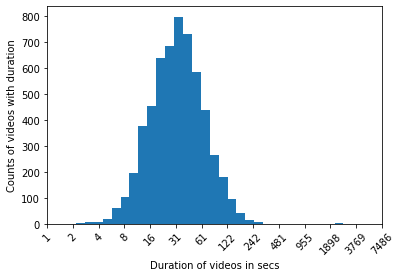

In [102]:
plt.hist(np.log2(list(zip(*files))[0]), bins=30)
positions = range(20, 34)
labels = [int(2 **(0.99 * (i - 20)) + 0.5) for i in positions]
plt.xticks(positions, labels, rotation=45)
plt.ylabel('Counts of videos with duration')
plt.xlabel('Duration of videos in secs');
plt.show()

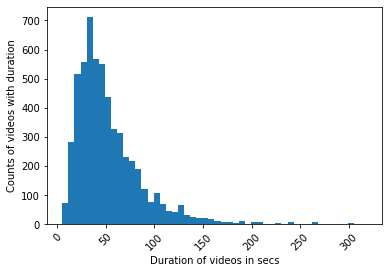

In [142]:
plt.close()
sizes = (np.array(list(zip(*files))[0]))
num_frames = (np.array(list(zip(*files))[2]))
durations = (num_frames / 1000)
time_cap = 10
durations[durations < time_cap] = num_frames[durations < time_cap] / 30
durations[durations < 0] = np.median(durations)
durations[durations > 500] = np.median(durations)
plt.hist(durations, bins=50)
plt.xticks(rotation=45)
plt.ylabel('Counts of videos with duration')
plt.xlabel('Duration of videos in secs')
plt.show()

In [104]:
np.sum(2 ** (np.log2(list(zip(*files))[0]) - 20))

251250.76688861847

In [128]:
a = np.array(list(zip(*files))[2], dtype=np.int)

In [133]:
a.argmax()

5275

In [134]:
files[5275]

(2156528481, 0.0, 2732165.0, 'p0003_r004_v002_a012.mkv')

In [34]:
import os
import cv2


def resize_dim(w, h, target):
    '''resize (w, h), such that the smaller side is target, keep the aspect ratio'''
    if w >= h:
        return (int(target * w / h), int(target))
    else:
        return (int(target), int(target * h / w)) 


def extract_video_opencv(v_path, f_root, dim):
    '''
        v_path: single video path;
        f_root: root to store frames
    '''
    
    v_class = v_path.split('/')[-2]
    v_name = os.path.basename(v_path)[0:-4]
    out_dir = os.path.join(f_root, v_class, v_name)
    if not os.path.exists(out_dir):
        print('Making dir', out_dir)

    vidcap = cv2.VideoCapture(v_path)
    nb_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float
    height = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT) # float
    if (width == 0) or (height == 0):
        print(v_path, 'not successfully loaded, drop ..'); 
        return
    new_dim = resize_dim(width, height, dim)
   
    success, image = vidcap.read()
    count = 1
    while success:
        image = cv2.resize(image, new_dim, interpolation = cv2.INTER_LINEAR)
        success, image = vidcap.read()
        count += 1
    
    # Correct the amount of frames
    if (count * 30) < nb_frames:
        nb_frames = int(nb_frames * 30 / 1000)
        
    print(nb_frames, height, width)
       
    if nb_frames > count:
        print('/'.join(out_dir.split('/')[-2::]), 'NOT extracted successfully: %df/%df' % (count, nb_frames))
    vidcap.release()


In [6]:
base_video_path = '/vision/u/nishantr/panasonic_data/action_split_data/V1.0'

In [30]:
import glob
files = glob.glob(base_video_path + "/p0003/*.mkv")
print('Total videos:', len(files))
for file in files:
    extract_video_opencv(file, '/scr/nishantr', dim=64)

Total videos: 245
Making dir /scr/nishantr/p0003/p0003_r002_v002_a008
Unable to convert into mp4 with code: 1. Try generating frames from original.
47342 768.0 1024.0
p0003/p0003_r002_v002_a008 NOT extracted successfully: 1384f/47342f
Making dir /scr/nishantr/p0003/p0003_r003_v000_a000
Unable to convert into mp4 with code: 1. Try generating frames from original.
70098 768.0 1024.0


KeyboardInterrupt: 

In [35]:
extract_video_opencv('/sailhome/nishantr/test_tmp.mp4', '/', dim=64)

Making dir /nishantr/test_tmp
1422 768.0 1024.0


In [36]:
extract_video_opencv('/vision/u/nishantr/panasonic_data/action_split_data/V1.0/p0003/p0003_r002_v002_a008.mkv', '/', dim=64)

Making dir /p0003/p0003_r002_v002_a008
1420 768.0 1024.0
p0003/p0003_r002_v002_a008 NOT extracted successfully: 1384f/1420f


In [13]:
import ffmpy
ff = ffmpy.FFmpeg(
    inputs={'/vision/u/nishantr/panasonic_data/action_split_data/V1.0/p0003/p0003_r002_v002_a008.mkv': None},
    outputs={'test_tmp.mp4': None}
)
ff.run()

(None, None)

In [129]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../train')

from dataset_3d import Panasonic_3d
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
from torchvision import transforms

dataset = Panasonic_3d(
            mode="val",
            transform={'audio': transforms.Compose([transforms.ToTensor()])},
            seq_len=5,
            num_seq=8,
            downsample=3,
            vals_to_return=['audio'],
            debug=True,
            dataset='panasonic',
            postfix='atomic')










  0%|          | 0/2062 [00:00<?, ?it/s]








 26%|██▋       | 545/2062 [00:00<00:00, 5447.59it/s]








 48%|████▊     | 986/2062 [00:00<00:00, 5086.94it/s]








 61%|██████▏   | 1267/2062 [00:00<00:00, 4088.95it/s]








 75%|███████▍  | 1539/2062 [00:00<00:00, 3551.92it/s]








100%|██████████| 2062/2062 [00:00<00:00, 3482.04it/s]


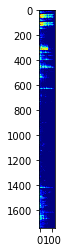

In [131]:
from dataset_3d import pil_loader

vpath = '/scr2/haofeng/panasonic/frame/p0007/p0007_r000_v000_a006'
person, vid = vpath.split('/')[-2:]
apath = '/scr/nishantr/panasonic/spectrogram/{}/{}_spec.jpg'.format(person, vid)
plt.imshow(pil_loader(apath))

In [132]:
data = dataset.__getitem__(0)

40 118 344 torch.Size([3, 1740, 128])


torch.Size([128, 344, 3])


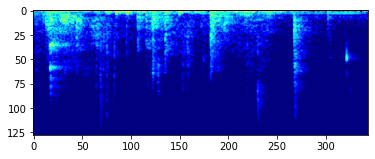

In [133]:
print(data['audio'].shape)
plt.imshow(data['audio'])

In [48]:
list(dataset.video_info.iloc[0])

['/scr2/haofeng/panasonic/frame/p0007/p0007_r000_v002_a006',
 31,
 120,
 'hold_cabinet',
 '/scr2/haofeng/panasonic/frame/p0007/p0007_r000_v000_a006',
 31.0,
 120.0,
 'hold_cabinet',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [172]:
sys.path.append('../backbone')
import vgg
from model_3d import AudioVGGEncoder

In [173]:
def custom_vgg():
    """VGG 19-layer tweaked model (configuration 'F') with batch normalization"""
    custom_cfg = list(vgg.cfg['E'])
    custom_cfg.extend([512, 'M', 512, 'M'])
    return vgg.VGG(vgg.make_layers(custom_cfg, batch_norm=True))

model = AudioVGGEncoder(args={'seq_len': 8, 'num_seq': 5, 'ds': 3})

In [180]:
model(data['audio'].permute(2, 0, 1).unsqueeze(0)).mean()

tensor(0.0780, grad_fn=<MeanBackward0>)

In [175]:
model.numReductions

2

In [176]:
model.numResidualElements

2